# Serena - Metrics Analysis

**I took a bunch of notes on my work computer and forgot to commit :( **

---

Notebook outcomes:
- Implement the different ways proposed of processing the hourly step data
- Investigate different methods of comparing the effectiveness of processing-- e.g. Machine Learning models
- Describe what Althoff et al did for processing and analysis in their paper and replicate


---

## Althoff et al's Implementation

Key things I remember:
- `Wear time` is defined as the span from the first step recorded to the last step recorded for the day
    - Now I already see potentiall issues with this, in that our data has the spread issue, whereas they used minute-by-minute incremental data and so wouldn't suffer from the same issue to a degree
- Compared average and distribution of step counts for different countries, ages, genders, and demographics
    - Did some simple tests to sanity check and verify with past results. E.g. females walk more than males on average 
- Their key driving question was seeing if the spread of step counts (step inequality) was a better predictor of obsesity than the average step count. 
    - And it seems like they only used correlations and bootstrapping as a method of comparison, so we could potentially use the same
    
    
---

# The Paper's Methodology

Nature and Scale of Dataset
- 68 million days spread over 717,527 people (so... 120 days per person?) -- from July 2013 to Dec 2014
- 111 countries around the world
- Collecting demographics on income inequality, obesity, gender, bmi, and age
- Data was minute-by-minute recordings from the Argus phone app

Processing Methods
- Filter out users with at least 10 days of step data
- Filter out countries with 1000 or more users
- Aggregated users to the country level
- Excluded users with missing reported values, e.g. height or weight in some analysis
- `Wear time` = the time between the first and last recorded step each day. Average wear time was 14 hours
    - Compared average wear time in each country against average daily steps, with no correlation


Methods of Analysis
- Compared the distribution of activity measurements across different countries
- Compared predictors of obesity -- average activity level vs activity inequality (betwee males and females)
- Related walkability of a city to average steps across age, gender, and BMI
- Compared demographic activity trends to previous research for sanity checking


Limitations of Analysis
- Biases towards higher socioeconomic groups in low income countries-- expected to decrease over time

---

## Reading in Serena's user data 

Because we know clear demographic metadata for this user, which will be useful to experiment with once we get more data.

First, importing packages

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
raw_data = pd.read_csv("../data/SUSS.csv")
raw_data.head()

,Start,Finish,Steps (count)
0,28-Nov-2015 12:00,28-Nov-2015 13:00,13.0
1,28-Nov-2015 13:00,28-Nov-2015 14:00,19.0
2,28-Nov-2015 14:00,28-Nov-2015 15:00,33.0
3,28-Nov-2015 15:00,28-Nov-2015 16:00,80.0
4,28-Nov-2015 16:00,28-Nov-2015 17:00,0.0


Most of the EDA has been done already, so we'll skip straight into the data cleaning before investigating processing methods

In [32]:
def clean_user(raw_df):
    raw_df['Start'] = pd.to_datetime(raw_df['Start'], format='%d-%b-%Y %H:%M')
    raw_df['Finish'] = pd.to_datetime(raw_df['Finish'], format='%d-%b-%Y %H:%M')
#     start_counts = raw_df['Start'].value_counts()
#     multicounts = start_counts[start_counts > 1]
    
    raw_df = raw_df[~ (raw_df['Start'] ==
        raw_df['Finish'])]
    
    return raw_df

def add_time_features(df):
    df = df.copy()
    df['year'] = df['Start'].dt.year
    df['month'] = df['Start'].dt.month
#     df['week'] = df['Start'].dt.isocalendar().week
    df['day'] = df['Start'].dt.day
    df['dayofweek'] = df['Start'].dt.dayofweek
    df['hour'] = df['Start'].dt.hour
    
    return df


In [36]:
df = clean_user(raw_data)
df.columns = ['Start', 'Finish', 'steps']
df = add_time_features(df)

In [37]:
df.head()

,Start,Finish,steps,year,month,day,dayofweek,hour
0,2015-11-28 12:00:00,2015-11-28 13:00:00,13.0,2015,11,28,5,12
1,2015-11-28 13:00:00,2015-11-28 14:00:00,19.0,2015,11,28,5,13
2,2015-11-28 14:00:00,2015-11-28 15:00:00,33.0,2015,11,28,5,14
3,2015-11-28 15:00:00,2015-11-28 16:00:00,80.0,2015,11,28,5,15
4,2015-11-28 16:00:00,2015-11-28 17:00:00,0.0,2015,11,28,5,16


In [55]:
df.describe()

,steps,year,month,day,dayofweek,hour
count,42789.000000,42789.000000,42789.000000,42789.000000,42789.000000,42789.000000
mean,194.989670,2017.856786,6.419547,15.689780,2.998528,11.501157
std,509.202404,1.423540,3.429168,8.811603,2.000531,6.921752
min,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000
25%,0.000000,2017.000000,3.000000,8.000000,1.000000,6.000000
50%,0.000000,2018.000000,6.000000,16.000000,3.000000,12.000000
75%,90.000000,2019.000000,9.000000,23.000000,5.000000,18.000000
max,6223.347475,2020.000000,12.000000,31.000000,6.000000,23.000000


--- 

First, we'll investigate Althoff's processing. This involves:
- Calculating wear time (time between first and last recorded step of the day)
- They observed an average wear time of around 14 hours. We'll see if this holds up. 


In [44]:
# Defining a flag for non-zero steps
df['nonzero_step_flag'] = (df['steps'] > 0)

In [64]:
df['time_nonzero'] = df.apply(lambda x: x['Start'].hour if x['nonzero_step_flag'] else None, axis=1)

daily_df = df.resample("D", on='Start')

In [73]:
weartime_df = daily_df.agg({'time_nonzero':['min', 'max'] , 'steps':['sum'], 'nonzero_step_flag':'sum'} )
weartime_df

time_nonzero         steps nonzero_step_flag
                    min   max     sum               sum
Start                                                  
2015-11-28         12.0  15.0   145.0               4.0
2015-11-29          6.0  21.0  4233.0              15.0
2015-11-30          6.0  20.0  4162.0              15.0
2015-12-01          6.0  20.0  3209.0              11.0
2015-12-02          6.0  20.0  2773.0              12.0
...                 ...   ...     ...               ...
2020-10-11          8.0  16.0  7016.0               7.0
2020-10-12          6.0  23.0  6555.0              13.0
2020-10-13          7.0  23.0  4409.0               9.0
2020-10-14          6.0  23.0  8285.0              15.0
2020-10-15          7.0  11.0   185.0               4.0

[1784 rows x 4 columns]

(I am a god)

We've defined a `time_nonzero` to indicate the hours where step data was recorded, and take the min and max of that to find our start and end recording times. 

This does come with the issue of hours where steps are recorded but show up as zero because the user doesn't walk. However, given that phones are sensitive to movement, even picking up the phone could be construed as a step. On observation and given domain knowledge of the user, the min times make sense (around 6-7am). The max times are a little less so, with some hours going up to 23, which suggests spread/sensor issues. 

In [74]:
weartime_df.columns = ['_'.join(x) for x in weartime_df.columns.ravel()]

In [75]:
weartime_df['weartime'] = weartime_df['time_nonzero_max'] - weartime_df['time_nonzero_min']

In [76]:
weartime_df.describe()

,time_nonzero_min,time_nonzero_max,steps_sum,nonzero_step_flag_sum,weartime
count,1784.000000,1784.000000,1784.000000,1784.000000,1784.000000
mean,6.545404,20.285314,4676.801009,10.867713,13.739910
std,1.274523,1.538034,3437.520580,2.672095,2.035484
min,0.000000,9.000000,8.000000,1.000000,0.000000
25%,6.000000,19.000000,2111.250000,9.000000,13.000000
50%,7.000000,21.000000,4167.000000,11.000000,14.000000
75%,7.000000,21.000000,6532.250000,13.000000,15.000000
max,17.000000,23.000000,20913.000000,18.000000,23.000000


Calculating Althoff's wear time from there, we find that the average wear time is 13.7 hours, which is consistent with what the paper found. 

Average steps per day is 4677 steps, with a standard deviation of 3437 steps. 

*Without further understanding of what they actually did in the paper, we'll standardise the step sums by the wear time to get steps per hour*

For days with zero wear time, we can either:
- impute with 0
- approximate with the average

But low wear times are also likely to be inaccurate, so we may want to extend this by only considering days where the wear time is greater than a certain level

In [84]:
weartime_df = weartime_df[weartime_df['weartime'] != 0]
weartime_df['steps_ph'] = (weartime_df['steps_sum']/weartime_df['weartime'])

/Users/Serena/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


---

Our Method 1: Continuous blocks of non-zero step counts >=10 hours


Isn't this just Althoff's extended?

We filter out the days where weartime is below 10 hours so that we ensure the user has been recording data for most of their day. 

In [86]:
contblock = weartime_df[weartime_df['weartime'] >=10]
contblock.describe()

,time_nonzero_min,time_nonzero_max,steps_sum,nonzero_step_flag_sum,weartime,steps_ph
count,1753.000000,1753.000000,1753.000000,1753.000000,1753.000000,1753.000000
mean,6.511124,20.361666,4699.782088,10.949230,13.850542,338.078620
std,1.225684,1.399752,3444.355363,2.609309,1.853794,242.453659
min,0.000000,16.000000,40.000000,4.000000,10.000000,3.076923
25%,6.000000,20.000000,2135.000000,9.000000,13.000000,153.500000
50%,7.000000,21.000000,4186.000000,11.000000,14.000000,299.307692
75%,7.000000,21.000000,6555.000000,13.000000,15.000000,472.687500
max,10.000000,23.000000,20913.000000,18.000000,23.000000,1730.750000


After filtering out low weartime days, we find that the average steps taken per day has increased slightly from 4677 to 4699, with a slightly higher standard deviation of 3444-- this can be attributed to the filtering out of many zero step counts that come with lower wear times

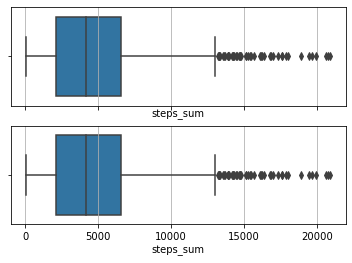

In [103]:
fig, axs= plt.subplots(2, sharex=True)
axs[0].grid()
axs[1].grid()
sns.boxplot(contblock['steps_sum'], ax=axs[0])
sns.boxplot(weartime_df['steps_sum'], ax=axs[1])


Boxplots show veeeery similar results

Our Method 2: Non-continuous block of non-zero step count >=10 hours

Here we consider all hours where the step count is non-zero, regardless of whether they were recorded as a block or not. 

This is actually kind of a dumb idea now that I think about it, because you're excluding all the zero step hours.

In [108]:
# weartime_df = daily_df.agg({'hour':['min', 'max'] , 'steps':['sum'], 'nonzero_step_flag':'sum'} )
noncont_df = df[df['nonzero_step_flag']].resample('D', on='Start')
noncontblock = noncont_df.agg({'steps':['sum'], 'nonzero_step_flag':'sum'})
noncontblock

,steps,nonzero_step_flag
,sum,sum
Start,,
2015-11-28,145.0,4.0
2015-11-29,4233.0,15.0
2015-11-30,4162.0,15.0
2015-12-01,3209.0,11.0
2015-12-02,2773.0,12.0
...,...,...
2020-10-11,7016.0,7.0
2020-10-12,6555.0,13.0


In [110]:
noncontblock.columns = ['_'.join(x) for x in noncontblock.columns.ravel()]
noncontblock = noncontblock[noncontblock['nonzero_step_flag_sum'] >=10]
noncontblock.describe()

,steps_sum,nonzero_step_flag_sum
count,1253.000000,1253.000000
mean,5420.161176,12.265762
std,3463.825055,1.656747
min,256.000000,10.000000
25%,2910.000000,11.000000
50%,4688.000000,12.000000
75%,7184.000000,13.000000
max,20913.000000,18.000000


Now, with this method, our actual step hours amount to around 12 hours a day, suggesting that for this user, on average, 2 hours are spent not walking at all (perhaps a lunch break?)

This measure should give us a better measure of how much they walk, conditional on the user walking during that hour.

Our average step count skyrockets to 5420 steps, with a very similar level of standard deviation (3464 steps)


Method 3: Apply a threshold level of steps to account for sensor recording errors. 

This may be the average of the steps from midnight to 5am, as step counts are usually lowest for most users in that.

In [113]:
hourly_agg = df.groupby('hour').agg({'steps': ['mean', 'count', 'sum', 'std','min', 'median', 'max']})
hourly_agg

steps                                                    \
            mean count            sum         std  min      median   
hour                                                                 
0       7.311959  1783   13037.222263  115.630472  0.0    0.000000   
1       1.889868  1783    3369.634786   40.694630  0.0    0.000000   
2       0.066367  1778     118.000000    2.798441  0.0    0.000000   
3       0.009534  1783      17.000000    0.402600  0.0    0.000000   
4       0.027630  1783      49.263420    0.632205  0.0    0.000000   
5       2.161412  1783    3853.797529   31.289253  0.0    0.000000   
6      51.224874  1783   91333.950798  230.173559  0.0    0.000000   
7     146.120159  1783  260532.242909  386.384555  0.0   51.000000   
8     446.946556  1783  796905.708783  709.699857  0.0  112.376162   
9     229.541447  1783  409272.399439  503.928019  0.0   41.116071   
10    270.177652  1783  481726.753657  575.206937  0.0   11.596978   
11    356.297936  1783  635279.220068  642.470891  0.0   69.000000   
12    394.609644  1784  703983.604346  631.681627  0.0  128.970417   
13    438.458976  1784  782210.813479  699.887039  0.0  124.740401   
14    483.227334  1783  861594.335799  712.876106  0.0  102.000000   
15    419.566258  1783  748086.638619  689.960602  0.0   48.233857   
16    245.079246  1783  436976.295486  535.397443  0.0   17.000000   
17    282.556677  1783  503798.555297  538.953746  0.0   72.000000   
18    445.019713  1783  793470.147477  838.245303  0.0   48.136988   
19    237.991327  1783  424338.536908  577.566788  0.0   15.000000   
20    110.052907  1783  196224.332519  382.440873  0.0    0.000000   
21     63.665584  1783  113515.737107  268.403635  0.0    0.000000   
22     32.682443  1783   58272.795687  219.072502  0.0    0.000000   
23     14.271460  1783   25446.013624  137.410382  0.0    0.000000   

                   
              max  
hour               
0     3267.848082  
1     1413.000000  
2      118.000000  
3       17.000000  
4       22.000000  
5      910.292559  
6     2900.000000  
7     6053.510367  
8     4351.860614  
9     4620.164888  
10    5103.667499  
11    5646.621374  
12    3858.590197  
13    5068.610788  
14    4465.044227  
15    6223.347475  
16    4474.627539  
17    4511.434208  
18    5420.000000  
19    4720.135743  
20    3789.709341  
21    3273.469045  
22    3065.252437  
23    2067.860327

Method 4: Filtering out outliers? 

- Steps per hour on a histogram
- Rolling window (Jeremy)


## Comparing different methods of processsing

Now, immediately, I'm gonna say we have a better shot at predicting the level of activity using our 10hr metric as opposed to Althoff's method of just a simple sum or average. 

But Althoff also has the advantage of a larger dataset to aggregate over, where variations in the individual are smoothed out over the whole population. 